# Agriculture
This notebook calculates the ETLocal keys of the Agriculture section. 

## Setup

### Parameters

In [14]:
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import importlib


import src.load_data_manager
import src.transform
import src.yaml_calculator
import src.helper
from src.load_data_manager import LoadDataManager
import config.yaml_to_diagram
from config.yaml_to_diagram import create_dependency_diagram

# Reload the modules to ensure latest version is used
importlib.reload(src.transform);
importlib.reload(src.yaml_calculator);
importlib.reload(src.helper);
importlib.reload(src.load_data_manager);
importlib.reload(config.yaml_to_diagram);

## General

### Parameters


We first specify general parameters to be used throughout this notebook.

In [15]:
# Select the parent data set. Make sure to use the geo ID. It should be existing in the Dataset Manager.
parent = "nl"

# Specify the year and the reference year for the ETM
year = 2023
year_etm = 2019

# Specify the CSV-separator (presumably either "," or ";")
sep=","

# Specify where the dependency graphs are stored
dep_graph_folder = Path("config","etlocal_keys_final_demand_dependency_outputs", "output")

# Specify where the yaml files with calculation rules are stored
yaml_folder = Path("config","yaml_files_for_etlocal_key_calculation")

## Extract and Transform

Here we define helper functions to be called for multiple cells throughout this specific notebook.

## Extract

In this section:
- We *Load* the relevant data from the data/intermediate folder
- We *Combine* the relevant data by merging municipal and national data

This is handled by the **ETLocalDataModule** which provides a unified interface for all data operations.

The module loads the following data sources:
- The ETLocal template (ETLocal_template_empty.csv)
- Klimaatmonitor data - both municipal and national levels with metadata:
  - km_source_data_converted.csv (municipal data)
  - km_meta_data_converted.csv (municipal metadata)
  - km_national_source_data_converted.csv (national data)
  - km_national_meta_data_converted.csv (national metadata)
- Transport research data (transport_research_cleaned.csv)
- Miscellaneous data (miscellaneous_data_analysis.csv)
- ETM query results (etm_query_combined.csv)

The module:
- Combines municipal-level data from different sources
- Combines national-level data from different sources
- Merges the municipal and national datasets into a single DataFrame
- Caches loaded data for improved performance

In [16]:
data_manager = LoadDataManager()
combined_data_without_ER = data_manager.combine_all_data(
    include_miscellaneous=True,
    include_etm_queries=True,
)
combined_data_without_ER

#If you want to view etm_queries, uncomment:
# etm_queries = data_manager.load_etm_queries_old()

Gemeentenaam ProvinciecodePV  Provincienaam  no_inhabitants  \
GM0014       Groningen            PV20      Groningen          238147   
GM0034          Almere            PV24      Flevoland          222825   
GM0037     Stadskanaal            PV20      Groningen           32135   
GM0047         Veendam            PV20      Groningen           27616   
GM0050        Zeewolde            PV24      Flevoland           23692   
...                ...             ...            ...             ...   
GM1979       Eemsdelta            PV20      Groningen           45394   
GM1980   Dijk en Waard            PV27  Noord-Holland           88985   
GM1982  Land van Cuijk            PV30  Noord-Brabant           91423   
GM1991       Maashorst            PV30  Noord-Brabant           58934   
GM1992  Voorne aan Zee            PV28   Zuid-Holland           73945   

        no_residences  no_cars  total_energy_tj  tp_total_energy_tj  \
GM0014         122715      NaN            15294                4045   
GM0034          90690      NaN            10680                3869   
GM0037          15177      NaN             1759                 534   
GM0047          13013      NaN                0                 580   
GM0050           9354      NaN             3139                1581   
...               ...      ...              ...                 ...   
GM1979          23587      NaN                0                1049   
GM1980          37459      NaN             5168                1350   
GM1982          39868      NaN             9022                3179   
GM1991          26012      NaN             4607                1761   
GM1992          33488      NaN             6758                1257   

        total_electricity_tj  total_gas_heat_tj_temp_corrected  ...  \
GM0014                  3218                              8031  ...   
GM0034                  2654                              4289  ...   
GM0037                   409                               815  ...   
GM0047                   786                                 0  ...   
GM0050                   765                               794  ...   
...                      ...                               ...  ...   
GM1979                  2026                                 0  ...   
GM1980                  1110                              2708  ...   
GM1982                  2073                              3769  ...   
GM1991                  1191                              1655  ...   
GM1992                  1024                              4476  ...   

        mq_buildings_final_demand_for_lighting_electricity_buildings_lighting_led_electricity_parent_share  \
GM0014                                           0.460186                                                    
GM0034                                           0.460186                                                    
GM0037                                           0.460186                                                    
GM0047                                           0.460186                                                    
GM0050                                           0.460186                                                    
...                                                   ...                                                    
GM1979                                           0.460186                                                    
GM1980                                           0.460186                                                    
GM1982                                           0.460186                                                    
GM1991                                           0.460186                                                    
GM1992                                           0.460186                                                    

        mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_airconditioning_electricity_pa

The `combined_data` dataframe misses data from Emissieregistratie and is implemented afterwards (including this in the LoadDataManager() is a nice-to-have)

In [17]:
path_ivar_er_data = Path("data", "intermediate", f"ER_final_demand_data_combined.csv")
df_ivar_er_data = pd.read_csv(path_ivar_er_data, sep=',')
df_ivar_er_data = df_ivar_er_data.copy()
df_ivar_er_data['GemeenteCode'] = df_ivar_er_data['GEMEENTECODE'].apply(lambda x: f"GM{int(x):04d}")
cols = ['GemeenteCode'] + [col for col in df_ivar_er_data.columns if col != 'GemeenteCode']
df_ivar_er_data = df_ivar_er_data[cols]
df_ivar_er_data = df_ivar_er_data.drop(columns=['GEMEENTECODE', 'GEMEENTENAAM'])
df_ivar_er_data = df_ivar_er_data.set_index('GemeenteCode')

In [18]:
combined_data = df_ivar_er_data.join(combined_data_without_ER, how='inner')  # alleen gemeenschappelijke indexen
combined_data


chemical_other_co2_scaled  food_co2_scaled  paper_co2_scaled  \
GM0014                   0.000280         0.042080          0.009533   
GM0034                   0.000153         0.002102          0.000283   
GM0037                   0.000042         0.000407          0.000000   
GM0047                   0.000813         0.000286          0.000000   
GM0050                   0.000091         0.000853          0.000000   
...                           ...              ...               ...   
GM1979                   0.040598         0.000335          0.000088   
GM1980                   0.000262         0.002509          0.000000   
GM1982                   0.000030         0.002475          0.012773   
GM1991                   0.000217         0.002884          0.000159   
GM1992                   0.000019         0.009624          0.000150   

        metal_other_co2_scaled  industry_other_co2_scaled  index  \
GM0014                     0.0                   0.003842    0.0   
GM0034                     0.0                   0.002355    0.0   
GM0037                     0.0                   0.001295    0.0   
GM0047                     0.0                   0.001504    0.0   
GM0050                     0.0                   0.000357    0.0   
...                        ...                        ...    ...   
GM1979                     0.0                   0.001949   14.0   
GM1980                     0.0                   0.002490    0.0   
GM1982                     0.0                   0.010847   31.0   
GM1991                     0.0                   0.002452   35.0   
GM1992                     0.0                   0.001398    0.0   

        aluminium_co2_scaled  index_dup  fertilizers_co2_scaled  index_dup.1  \
GM0014              0.000000        0.0                     0.0          110   
GM0034              0.000000        0.0                     0.0           10   
GM0037              0.000000        0.0                     0.0          262   
GM0047              0.000000        0.0                     0.0          289   
GM0050              0.000000        0.0                     0.0          333   
...                      ...        ...                     ...          ...   
GM1979              0.035017        0.0                     0.0           88   
GM1980              0.000000        0.0                     0.0           72   
GM1982              0.000809        0.0                     0.0          157   
GM1991              0.003237        0.0                     0.0          177   
GM1992              0.000000        0.0                     0.0          301   

        ...  \
GM0014  ...   
GM0034  ...   
GM0037  ...   
GM0047  ...   
GM0050  ...   
...     ...   
GM1979  ...   
GM1980  ...   
GM1982  ...   
GM1991  ...   
GM1992  ...   

        mq_buildings_final_demand_for_lighting_electricity_buildings_lighting_led_electricity_parent_share  \
GM0014                                           0.460186                                                    
GM0034                                           0.460186                                                    
GM0037                                           0.460186                                                    
GM0047                                           0.460186                                                    
GM0050                                           0.460186                                                    
...                                                   ...                                                    
GM1979                                           0.460186                                                    
GM1980                                           0.460186                                                    
GM1982                                           0.460186                                                    
GM1991                                           0.460186                           

## Run YamlCalculator

#### Electricity final demand

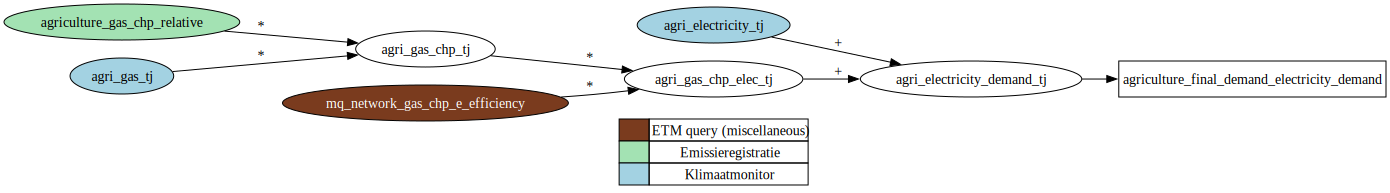

In [19]:
# Define ETLocal key
etlocal_key = "agriculture_final_demand_electricity_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [20]:
# key = 'agri_gas_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])


Describe output key for the commit message by describing the last step:

In [21]:
sector = 'agriculture'
output_description = 'Final electricity demand'
arithmic_op= ['add','add']
vars_description = ['electricity demand for agriculture, forestry and fisheries (SBI A)',"electricity generated by combined heat and power (CHP) installations. The CHP demand is estimated based on the relative gas demand of CHPs (Emissieregistratie), the gas demand in agriculture (Klimaatmonitor), and an estimation of the CHP-efficiency (ETM)"]
vars_source = ['Klimaatmonitor','Quintel estimation, Emissieregistratie, and Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final electricity demand in the agriculture sector is calculated by adding electricity demand for agriculture, forestry and fisheries (SBI A) (Klimaatmonitor, 2023) to electricity generated by combined heat and power (CHP) installations. The CHP demand is estimated based on the relative gas demand of CHPs (Emissieregistratie), the gas demand in agriculture (Klimaatmonitor), and an estimation of the CHP-efficiency (ETM) (Quintel estimation, Emissieregistratie, and Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [22]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

agriculture_final_demand_electricity_demand  agri_gas_chp_tj  \
GM0014                                    19.442426         1.427099   
GM0034                                   152.531005       320.027582   
GM0037                                    13.874055         0.057445   
GM0047                                    11.588400         0.000000   
GM0050                                    81.799200         0.000000   
...                                             ...              ...   
GM1979                                    43.546150         2.151757   
GM1980                                   355.993093       760.280792   
GM1982                                   239.958145       128.919312   
GM1991                                    99.667602        12.555682   
GM1992                                   976.895969      2206.196672   

        agri_gas_chp_elec_tj  agri_electricity_demand_tj error_message  \
GM0014              0.528026                   19.442426           NaN   
GM0034            118.410205                  152.531005           NaN   
GM0037              0.021255                   13.874055           NaN   
GM0047              0.000000                   11.588400           NaN   
GM0050              0.000000                   81.799200           NaN   
...                      ...                         ...           ...   
GM1979              0.796150                   43.546150           NaN   
GM1980            281.303893                  355.993093           NaN   
GM1982             47.700145                  239.958145           NaN   
GM1991              4.645602                   99.667602           NaN   
GM1992            816.292769                  976.895969           NaN   

                                                   commit  
GM0014  Final electricity demand in the agriculture se...  
GM0034  Final electricity demand in the agriculture se...  
GM0037  Final electricity demand in the agriculture se...  
GM0047  Final electricity demand in the agriculture se...  
GM0050  Final electricity demand in the agriculture se...  
...                                                   ...  
GM1979  Final electricity demand in the agriculture se...  
GM1980  Final electricity demand in the agriculture se...  
GM1982  Final electricity demand in the agriculture se...  
GM1991  Final electricity demand in the agriculture se...  
GM1992  Final electricity demand in the agriculture se...  

[342 rows x 6 columns]

3. Add data to template

In [23]:
df_template_local = data_manager.load_template(group='agriculture')
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group       subgroup                  key                                                       
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_hydrogen_demand             TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
                                             agriculture_final_demand_wood_pellets_demand         TJ   
                                             input_agriculture_final_demand_crude_oil_demand      TJ   
...                                                                                              ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...    %   
                                             input_percentage_of_lpg_agriculture_final_deman...    %   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   

                                                                                                     value  \
geo_id group       subgroup                  key                                                             
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         19.442426   
                                             agriculture_final_demand_hydrogen_demand                  NaN   
                                             agriculture_final_demand_network_gas_demand               NaN   
                                             agriculture_final_demand_wood_pellets_demand              NaN   
                                             input_agriculture_final_demand_crude_oil_demand           NaN   
...                                                                                                    ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...        NaN   
                                             input_percentage_of_lpg_agriculture_final_deman...        NaN   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                      NaN   
                                             agriculture_chp_engine_network_gas_dispatchable...        NaN   
                                             agriculture_chp_wood_pellets_demand                       NaN   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         Final electricity demand in the agriculture se...  
                                             agriculture_final_demand_hydrogen_demand                                                          nan  
                                             agriculture_final_demand_network_gas_demand                                                       nan  
                                             agriculture_final_demand_wood_pellets_demand                                                      nan  
                                             input_agriculture_final_demand_crude_oil_demand                                                   nan  
...                                                                                                                                            ...  
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...                         

4. Use validation function to quick-scan data

In [24]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: agriculture_final_demand_electricity_demand
total_rows: 342
zero_count: 2
nan_count: 0
min_value: 0.0
max_value: 10502.645721
mean_value: 142.60431327246053
median_value: 23.211201568499998


In [25]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: agriculture_final_demand_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 297 municipalities (87.9%)
  medium_diff: 37 municipalities (10.9%)
  exact_match: 2 municipalities (0.6%)
  small_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=10502.65, Mean=139.34
  Verification: Min=0.00, Max=14940.04, Mean=190.07
  Abs diff:     Min=0.00, Max=4437.40, Mean=54.13

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1783: Templat

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM1783    10502.645721        14940.04488   4437.399159     -29.701378   
GM1621     2885.043564         4064.90544   1179.861876     -29.025568   
GM0851     1306.022591        2316.615252   1010.592661     -43.623673   
GM0451      104.709600        1004.321424    899.611824     -89.574095   
GM1842      690.109204          1531.0466    840.937396     -54.925656   
...                ...                ...           ...            ...   
GM0308        2.365200             2.5236        0.1584      -6.276748   
GM0917        3.867143           3.967219      0.100076      -2.522574   
GM0293        0.230400             0.2988        0.0684     -22.891566   
GM0096        0.000000                  0           0.0       0.000000   
GM0277        0.000000                  0           0.0       0.000000   

             status  
GM1783   large_diff  
GM1621   large_diff  
GM0851   large_diff  
GM0451   large_diff  
GM1842   large_diff  
...             ...  
GM0308  medium_diff  
GM0917  medium_diff  
GM0293   large_diff  
GM0096  exact_match  
GM0277  exact_match  

[338 rows x 5 columns]

#### Network gas final demand

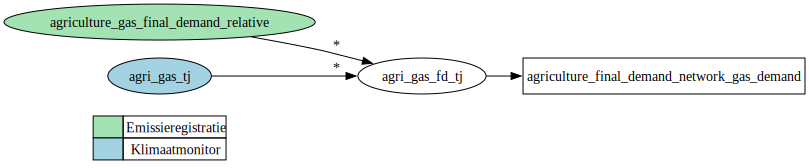

In [26]:
# Define ETLocal key
etlocal_key = "agriculture_final_demand_network_gas_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [27]:
key = 'agri_gas_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Aardgas geleverd aan Landbouw, bosbouw en visserij (SBI A)


In [28]:
# key = 'agri_gas_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

sector = 'agriculture'
output_description = 'Final gas demand'
arithmic_op= ['subtract','subtract']
vars_description = ['gas demand for agriculture, forestry and fisheries (SBI A)',"gas demand from Combined Heat and Power (CHP) installations (Emissieregistratie)"]
vars_source = ['Klimaatmonitor','Emissieregistratie']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final gas demand in the agriculture sector is calculated by subtracting gas demand from Combined Heat and Power (CHP) installations (Emissieregistratie) (Emissieregistratie, 2023) from gas demand for agriculture, forestry and fisheries (SBI A) (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [29]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

agriculture_final_demand_network_gas_demand  agri_gas_fd_tj  \
GM0014                                    25.000652       25.000652   
GM0034                                     2.580868        2.580868   
GM0037                                    11.431505       11.431505   
GM0047                                     8.165700        8.165700   
GM0050                                   219.619350      219.619350   
...                                             ...             ...   
GM1979                                    37.695593       37.695593   
GM1980                                    24.322709       24.322709   
GM1982                                   408.244488      408.244488   
GM1991                                    55.681718       55.681718   
GM1992                                     8.860228        8.860228   

       error_message                                             commit  
GM0014           NaN  Final gas demand in the agriculture sector is ...  
GM0034           NaN  Final gas demand in the agriculture sector is ...  
GM0037           NaN  Final gas demand in the agriculture sector is ...  
GM0047           NaN  Final gas demand in the agriculture sector is ...  
GM0050           NaN  Final gas demand in the agriculture sector is ...  
...              ...                                                ...  
GM1979           NaN  Final gas demand in the agriculture sector is ...  
GM1980           NaN  Final gas demand in the agriculture sector is ...  
GM1982           NaN  Final gas demand in the agriculture sector is ...  
GM1991           NaN  Final gas demand in the agriculture sector is ...  
GM1992           NaN  Final gas demand in the agriculture sector is ...  

[342 rows x 4 columns]

3. Add data to template

In [30]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group       subgroup                  key                                                       
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_hydrogen_demand             TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
                                             agriculture_final_demand_wood_pellets_demand         TJ   
                                             input_agriculture_final_demand_crude_oil_demand      TJ   
...                                                                                              ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...    %   
                                             input_percentage_of_lpg_agriculture_final_deman...    %   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   

                                                                                                     value  \
geo_id group       subgroup                  key                                                             
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         19.442426   
                                             agriculture_final_demand_hydrogen_demand                  NaN   
                                             agriculture_final_demand_network_gas_demand         25.000652   
                                             agriculture_final_demand_wood_pellets_demand              NaN   
                                             input_agriculture_final_demand_crude_oil_demand           NaN   
...                                                                                                    ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...        NaN   
                                             input_percentage_of_lpg_agriculture_final_deman...        NaN   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                      NaN   
                                             agriculture_chp_engine_network_gas_dispatchable...        NaN   
                                             agriculture_chp_wood_pellets_demand                       NaN   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         Final electricity demand in the agriculture se...  
                                             agriculture_final_demand_hydrogen_demand                                                          nan  
                                             agriculture_final_demand_network_gas_demand         Final gas demand in the agriculture sector is ...  
                                             agriculture_final_demand_wood_pellets_demand                                                      nan  
                                             input_agriculture_final_demand_crude_oil_demand                                                   nan  
...                                                                                                                                            ...  
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...                         

4. Use validation function to quick-scan data

In [31]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: agriculture_final_demand_network_gas_demand
total_rows: 342
zero_count: 26
nan_count: 0
min_value: 0.0
max_value: 454.84822679999945
mean_value: 26.179445292543853
median_value: 7.0578234


In [32]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: agriculture_final_demand_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 317 municipalities (93.8%)
  exact_match: 10 municipalities (3.0%)
  medium_diff: 6 municipalities (1.8%)
  small_diff: 5 municipalities (1.5%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=454.85, Mean=25.02
  Verification: Min=0.00, Max=1387.33, Mean=47.45
  Abs diff:     Min=0.00, Max=998.12, Mean=30.14

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1894: Template=184.7

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM1894      184.712692        1182.833738    998.121046     -84.383884   
GM0171      436.723854        1387.329183    950.605329     -68.520531   
GM1911      454.848227                  0    454.848227       0.000000   
GM1507      147.501217         598.141323    450.640106     -75.340072   
GM0851       38.556916         349.702021    311.145105     -88.974351   
...                ...                ...           ...            ...   
GM0597        0.000000                  0           0.0       0.000000   
GM0590        0.000000                  0           0.0       0.000000   
GM0531        0.000000                  0           0.0       0.000000   
GM0518        0.000000                  0           0.0       0.000000   
GM1621        0.000000                  0           0.0       0.000000   

             status  
GM1894   large_diff  
GM0171   large_diff  
GM1911   small_diff  
GM1507   large_diff  
GM0851   large_diff  
...             ...  
GM0597  exact_match  
GM0590  exact_match  
GM0531  exact_match  
GM0518  exact_match  
GM1621  exact_match  

[338 rows x 5 columns]

#### Biomass final demand

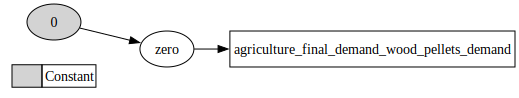

In [33]:
# Define ETLocal key
etlocal_key = "agriculture_final_demand_wood_pellets_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [34]:
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'agriculture_final_demand_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


#### Hydrogen final demand

In [35]:
# Define ETLocal key
etlocal_key = "agriculture_final_demand_hydrogen_demand"

df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'agriculture_final_demand_hydrogen_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


#### Crude oil final demand

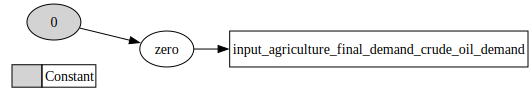

In [36]:
# Define ETLocal key
etlocal_key = "input_agriculture_final_demand_crude_oil_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [37]:
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_agriculture_final_demand_crude_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


#### Heat final demand

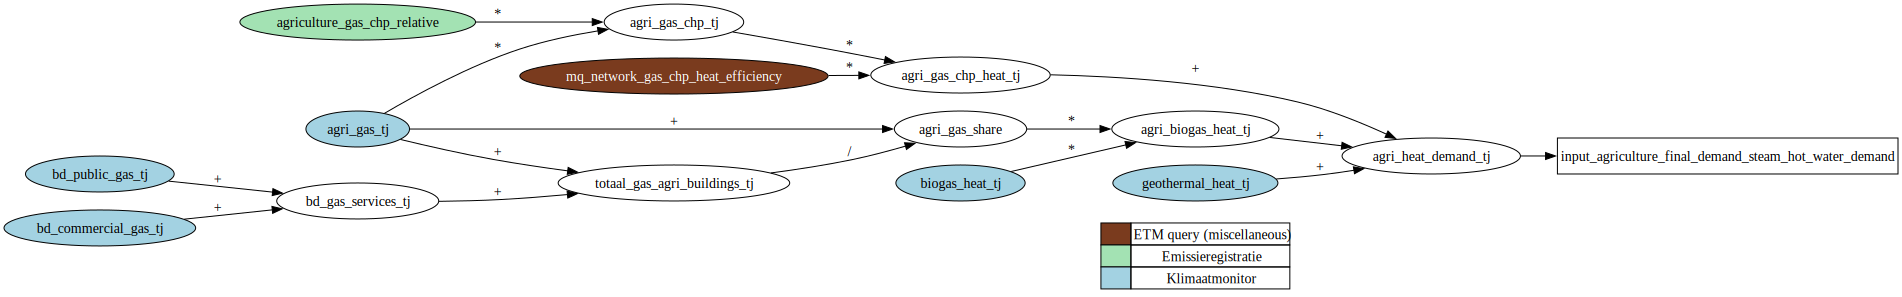

In [38]:
# Define ETLocal key
etlocal_key = "input_agriculture_final_demand_steam_hot_water_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [39]:
key = 'biogas_heat_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Biogas bekende hernieuwbare warmte


In [40]:
# key = 'agri_gas_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

# sector = 'agriculture'
# output_description = 'Final heat demand'
# arithmic_op= ['add','add', 'add']
# vars_description = ["the heat demand for combined heat and power (CHP) installations",'biogas',"geothermal energy"]
# vars_source = ['Klimaatmonitor, Emissieregistratie and miscellaneous','Klimaatmonitor','Klimaatmonitor']

# message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
message = 'The final heat demand is calculated based on heat from combined heat and power (CHP) installations, biogas heat, and geothermal heat (Klimaatmonitor, 2023). For heat from CHP installations, the total gas demand in agriculture, forestry, and fisheries (SBI A) (Klimaatmonitor, 2023) is multiplied by the ratio of CHP gas demand to total gas demand (Emissieregistratie, 2023), and then adjusted by an efficiency factor for gas-to-heat conversion (ETM). Biogas heat is estimated by multiplying the total biogas heat demand (Klimaatmonitor) by the gas share, which is calculated as the ratio of gas demand in agriculture, forestry, and fisheries to the gas demand in these sectors plus buildings (Klimaatmonitor, 2023).'
print(message)

# final heat demand is based on
# (1) heat from CHP installations
# (2) biogas heat
# (3) geothermal heat (Klimaatmonitor)

# (1.1) Total gas demand in agriculture, forestry and fisheries (SBI A) multiplied by the (CHP gas demand):(total gas demand) ratio - to estimate the gas demand for CHP installations. Subsequently this is multiplied by a gas to heat efficiency factor (for CHPs)
# (2.1) Biogas heat is estimated based on the total biogas heat demand (klimaatmonitor) multiplied by the gas share 
#   (2.2) The gas share is calculated as the ratio of the total gas demand in agriculture, forestry and fisheries (SBI A) to the total gas demand in agriculture, forestry and fisheries (SBI A) and buildings.
# 




The final heat demand is calculated based on heat from combined heat and power (CHP) installations, biogas heat, and geothermal heat (Klimaatmonitor, 2023). For heat from CHP installations, the total gas demand in agriculture, forestry, and fisheries (SBI A) (Klimaatmonitor, 2023) is multiplied by the ratio of CHP gas demand to total gas demand (Emissieregistratie, 2023), and then adjusted by an efficiency factor for gas-to-heat conversion (ETM). Biogas heat is estimated by multiplying the total biogas heat demand (Klimaatmonitor) by the gas share, which is calculated as the ratio of gas demand in agriculture, forestry, and fisheries to the gas demand in these sectors plus buildings (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [41]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

input_agriculture_final_demand_steam_hot_water_demand  \
GM0014                                           1.527014       
GM0034                                         153.613240       
GM0037                                           0.027573       
GM0047                                           0.379201       
GM0050                                           0.000000       
...                                                   ...       
GM1979                                           1.032843       
GM1980                                         364.934780       
GM1982                                          71.536391       
GM1991                                           6.026727       
GM1992                                        1599.974403       

        agri_gas_chp_tj  agri_gas_chp_heat_tj  bd_gas_services_tj  \
GM0014         1.427099              0.685007         1574.290212   
GM0034       320.027582            153.613240          244.512771   
GM0037         0.057445              0.027573          147.978341   
GM0047         0.000000              0.000000          142.571919   
GM0050         0.000000              0.000000          188.402354   
...                 ...                   ...                 ...   
GM1979         2.151757              1.032843          277.920296   
GM1980       760.280792            364.934780          229.665123   
GM1982       128.919312             61.881270          408.633150   
GM1991        12.555682              6.026727          340.870500   
GM1992      2206.196672           1058.974403          255.099000   

        totaal_gas_agri_buildings_tj  agri_gas_share  agri_biogas_heat_tj  \
GM0014                   1600.717962        0.016510             0.842007   
GM0034                    567.121221        0.568853             0.000000   
GM0037                    159.467291        0.072046             0.000000   
GM0047                    150.737619        0.054172             0.379201   
GM0050                    408.021704        0.538254             0.000000   
...                              ...             ...                  ...   
GM1979                    317.767646        0.125398             0.000000   
GM1980                   1014.268623        0.773566             0.000000   
GM1982                    945.796950        0.567948             9.655122   
GM1991                    409.107900        0.166796             0.000000   
GM1992                   2470.155900        0.896728             0.000000   

        agri_heat_demand_tj error_message  \
GM0014             1.527014           NaN   
GM0034           153.613240           NaN   
GM0037             0.027573           NaN   
GM0047             0.379201           NaN   
GM0050             0.000000           NaN   
...                     ...           ...   
GM1979             1.032843           NaN   
GM1980           364.934780           NaN   
GM1982            71.536391           NaN   
GM1991             6.026727           NaN   
GM1992          1599.974403           NaN   

                                                   commit  
GM0014  The final heat demand is calculated based on h...  
GM0034  The final heat demand is calculated based on h...  
GM0037  The final heat demand is calculated based on h...  
GM0047  The final heat demand is calculated based on h...  
GM0050  The final heat demand is calculated based on h...  
...                                                   ...  
GM1979  The final heat demand is calculated based on h...  
GM1980  The final heat demand is calculated based on h...  
GM1982  The final heat demand is calculated based on h...  
GM1991  The final heat demand is calculated based on h...  
GM1992  The final heat demand is calculated based on h...  

[342 rows x 10 columns]

3. Add data to template

In [42]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group       subgroup                  key                                                       
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_hydrogen_demand             TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
                                             agriculture_final_demand_wood_pellets_demand         TJ   
                                             input_agriculture_final_demand_crude_oil_demand      TJ   
...                                                                                              ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...    %   
                                             input_percentage_of_lpg_agriculture_final_deman...    %   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   

                                                                                                     value  \
geo_id group       subgroup                  key                                                             
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         19.442426   
                                             agriculture_final_demand_hydrogen_demand             0.000000   
                                             agriculture_final_demand_network_gas_demand         25.000652   
                                             agriculture_final_demand_wood_pellets_demand         0.000000   
                                             input_agriculture_final_demand_crude_oil_demand      0.000000   
...                                                                                                    ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...        NaN   
                                             input_percentage_of_lpg_agriculture_final_deman...        NaN   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                      NaN   
                                             agriculture_chp_engine_network_gas_dispatchable...        NaN   
                                             agriculture_chp_wood_pellets_demand                       NaN   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         Final electricity demand in the agriculture se...  
                                             agriculture_final_demand_hydrogen_demand            No data available. Set to 0 for all municipali...  
                                             agriculture_final_demand_network_gas_demand         Final gas demand in the agriculture sector is ...  
                                             agriculture_final_demand_wood_pellets_demand        No data available. Set to 0 for all municipali...  
                                             input_agriculture_final_demand_crude_oil_demand     No data available. Set to 0 for all municipali...  
...                                                                                                                                            ...  
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...                         

4. Use validation function to quick-scan data

In [43]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: input_agriculture_final_demand_steam_hot_water_demand
total_rows: 342
zero_count: 55
nan_count: 0
min_value: 0.0
max_value: 12306.999983999998
mean_value: 141.54122305850044
median_value: 0.703002204


In [44]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_agriculture_final_demand_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (337 municipalities):
  large_diff: 259 municipalities (76.9%)
  exact_match: 45 municipalities (13.4%)
  medium_diff: 20 municipalities (5.9%)
  small_diff: 13 municipalities (3.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=12307.00, Mean=137.58
  Verification: Min=0.00, Max=15977.10, Mean=163.08
  Abs diff:     Min=0.00, Max=3670.10, Mean=52.47

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM1783    12306.999984         15977.0956   3670.095616     -22.970981   
GM1911     3411.291404               1122   2289.291404     204.036667   
GM0451        0.000000         1036.22028    1036.22028    -100.000000   
GM1621     3681.411456          4689.2298   1007.818344     -21.492194   
GM0171     2177.527918        1180.820077    996.707841      84.408104   
...                ...                ...           ...            ...   
GM0606        0.000000                  0           0.0       0.000000   
GM0512        0.000000                  0           0.0       0.000000   
GM0308        0.000000                  0           0.0       0.000000   
GM0505        0.000000                  0           0.0       0.000000   
GM0473        0.000000                  0           0.0       0.000000   

             status  
GM1783   large_diff  
GM1911   large_diff  
GM0451   large_diff  
GM1621   large_diff  
GM0171   large_diff  
...             ...  
GM0606  exact_match  
GM0512  exact_match  
GM0308  exact_match  
GM0505  exact_match  
GM0473  exact_match  

[337 rows x 5 columns]

#### Agriculture (17_oil_split) keys
(.yamls bestaan (nog) niet)

#### Network gas CHP demand

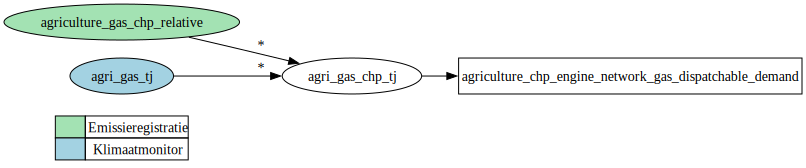

In [45]:

# Define ETLocal key
etlocal_key = "agriculture_chp_engine_network_gas_dispatchable_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [46]:
key = 'agri_gas_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Aardgas geleverd aan Landbouw, bosbouw en visserij (SBI A)


In [47]:
# key = 'agri_gas_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

sector = 'agriculture'
output_description = 'Final gas demand'
arithmic_op= ['subtract','subtract']
vars_description = ['gas demand for agriculture, forestry and fisheries (SBI A)',"gas demand without Combined Heat and Power (CHP) installations (Emissieregistratie)"]
vars_source = ['Klimaatmonitor','Emissieregistratie']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final gas demand in the agriculture sector is calculated by subtracting gas demand without Combined Heat and Power (CHP) installations (Emissieregistratie) (Emissieregistratie, 2023) from gas demand for agriculture, forestry and fisheries (SBI A) (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [48]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

agriculture_chp_engine_network_gas_dispatchable_demand  \
GM0014                                           1.427099        
GM0034                                         320.027582        
GM0037                                           0.057445        
GM0047                                           0.000000        
GM0050                                           0.000000        
...                                                   ...        
GM1979                                           2.151757        
GM1980                                         760.280792        
GM1982                                         128.919312        
GM1991                                          12.555682        
GM1992                                        2206.196672        

        agri_gas_chp_tj error_message  \
GM0014         1.427099           NaN   
GM0034       320.027582           NaN   
GM0037         0.057445           NaN   
GM0047         0.000000           NaN   
GM0050         0.000000           NaN   
...                 ...           ...   
GM1979         2.151757           NaN   
GM1980       760.280792           NaN   
GM1982       128.919312           NaN   
GM1991        12.555682           NaN   
GM1992      2206.196672           NaN   

                                                   commit  
GM0014  Final gas demand in the agriculture sector is ...  
GM0034  Final gas demand in the agriculture sector is ...  
GM0037  Final gas demand in the agriculture sector is ...  
GM0047  Final gas demand in the agriculture sector is ...  
GM0050  Final gas demand in the agriculture sector is ...  
...                                                   ...  
GM1979  Final gas demand in the agriculture sector is ...  
GM1980  Final gas demand in the agriculture sector is ...  
GM1982  Final gas demand in the agriculture sector is ...  
GM1991  Final gas demand in the agriculture sector is ...  
GM1992  Final gas demand in the agriculture sector is ...  

[342 rows x 4 columns]

3. Add data to template

In [49]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group       subgroup                  key                                                       
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_hydrogen_demand             TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
                                             agriculture_final_demand_wood_pellets_demand         TJ   
                                             input_agriculture_final_demand_crude_oil_demand      TJ   
...                                                                                              ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...    %   
                                             input_percentage_of_lpg_agriculture_final_deman...    %   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   

                                                                                                       value  \
geo_id group       subgroup                  key                                                               
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand           19.442426   
                                             agriculture_final_demand_hydrogen_demand               0.000000   
                                             agriculture_final_demand_network_gas_demand           25.000652   
                                             agriculture_final_demand_wood_pellets_demand           0.000000   
                                             input_agriculture_final_demand_crude_oil_demand        0.000000   
...                                                                                                      ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...          NaN   
                                             input_percentage_of_lpg_agriculture_final_deman...          NaN   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                        NaN   
                                             agriculture_chp_engine_network_gas_dispatchable...  2206.196672   
                                             agriculture_chp_wood_pellets_demand                         NaN   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         Final electricity demand in the agriculture se...  
                                             agriculture_final_demand_hydrogen_demand            No data available. Set to 0 for all municipali...  
                                             agriculture_final_demand_network_gas_demand         Final gas demand in the agriculture sector is ...  
                                             agriculture_final_demand_wood_pellets_demand        No data available. Set to 0 for all municipali...  
                                             input_agriculture_final_demand_crude_oil_demand     No data available. Set to 0 for all municipali...  
...                                                                                                                                            ...  
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric..

4. Use validation function to quick-scan data

In [50]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: agriculture_chp_engine_network_gas_dispatchable_demand
total_rows: 342
zero_count: 64
nan_count: 0
min_value: 0.0
max_value: 22908.3333
mean_value: 253.54667883026318
median_value: 1.2515201249999999


In [51]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: agriculture_chp_engine_network_gas_dispatchable_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 250 municipalities (74.0%)
  exact_match: 56 municipalities (16.6%)
  medium_diff: 18 municipalities (5.3%)
  small_diff: 14 municipalities (4.1%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=22908.33, Mean=247.35
  Verification: Min=0.00, Max=28856.19, Mean=273.24
  Abs diff:     Min=0.00, Max=5947.86, Mean=95.96

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM1783    22908.333300         28856.1912     5947.8579     -20.612069   
GM1911     4713.881623                  0   4713.881623       0.000000   
GM0171     2660.608446                  0   2660.608446       0.000000   
GM1842     1865.160010                  0    1865.16001       0.000000   
GM0851     3174.519434        4869.731129   1695.211695     -34.811197   
...                ...                ...           ...            ...   
GM0339        0.000000                  0           0.0       0.000000   
GM0981        0.000000                  0           0.0       0.000000   
GM0971        0.000000                  0           0.0       0.000000   
GM0965        0.000000                  0           0.0       0.000000   
GM0622        0.000000                  0           0.0       0.000000   

             status  
GM1783   large_diff  
GM1911   small_diff  
GM0171   small_diff  
GM1842   small_diff  
GM0851   large_diff  
...             ...  
GM0339  exact_match  
GM0981  exact_match  
GM0971  exact_match  
GM0965  exact_match  
GM0622  exact_match  

[338 rows x 5 columns]

#### Biogas CHP demand

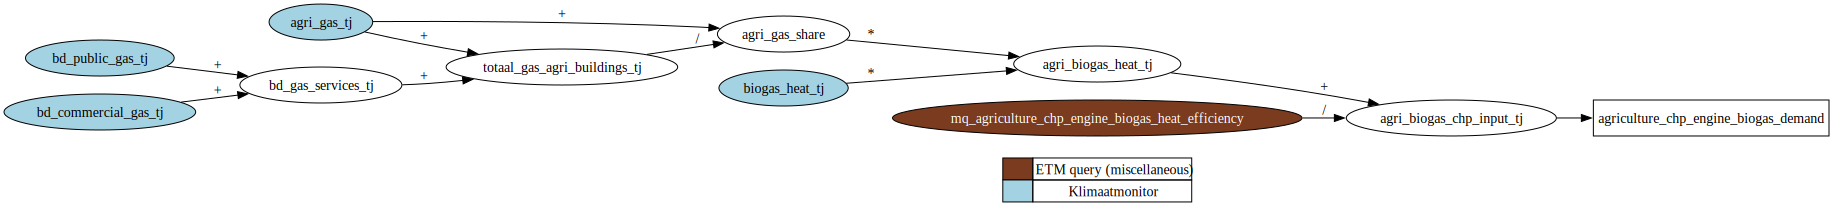

In [52]:
# Define ETLocal key
etlocal_key = "agriculture_chp_engine_biogas_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [53]:
key = 'bd_public_gas_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Aardgasverbruik Publieke Dienstverlening


In [54]:
# key = 'agri_gas_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

# sector = 'agriculture'
# output_description = 'Final biogas demand for Combined Heat and Power (CHP) installations'
# arithmic_op= ['add','divid']
# vars_description = ['biogas demand for agriculture, forestry and fisheries',"biogas heat efficiency"]
# vars_source = ['Klimaatmonitor','miscellaneous']

# vraag naar biogas  voor landbouw en gebouwen (klimaatmonitor) 
# Vermenigvuldigen:
# verhouding totaal gasvraag landbouw  in het totale gasverbruik landbouw en gebouwen (klimaatmonitor)
# --> totale biogasvraag voor warmte in landbouw
# vervolgens finale vraag bio gas --> efficiency van een biogas wkk (ETM) bepaald wat dan de totale biogasvraag van WKK's is.

#De biogasvraag voor warmte in de landbouw wordt bepaald door de totale vraag naar biogas voor warmte voor landbouw en gebouwen (volgens de Klimaatmonitor) te vermenigvuldigen met de verhouding van de totale gasvraag in de landbouw ten opzichte van het totale gasverbruik van landbouw en gebouwen. Vervolgens wordt de uiteindelijke biogasvraag voor warmtekrachtkoppelingen (WKK’s) berekend aan de hand van de efficiëntie van een biogas-WKK (volgens ETM).

# message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)

# message = 'The biogas demand for heat includes both agricultural and commercial sector demand (Klimaatmonitor, 2023). Based on the emissions from gas usage in agriculture and the commercial sector (Emissieregistratie, 2023) the ratio between gas demand in agriculture and in the commercial sector is determined. This ratio is then used to calculate the share of the total biogas heat demand for agriculture. Using the resulting biogas demand for heat in agriculture, the final biogas demand in CHP’s is calculated by using the efficiency of a biogas CHP (ETM).'
# message = "The biogas demand for heat includes both agricultural and commercial sector demand (Klimaatmonitor, 2023). Using emissions data from gas use in these sectors (Emissieregistratie, 2023), the ratio of gas demand between agriculture and commericial is calculated. This ratio helps determine agriculture's share of total biogas heat demand. The final biogas demand for CHP installations is then calculated by applying the efficiency of a biogas CHP (ETM) to the agricultural biogas heat demand."
message = "The biogas demand for heat includes both agricultural and commercial sector demand (Klimaatmonitor, 2023). Using emissions data from gas use in these sectors (Emissieregistratie, 2023), the ratio of gas demand between agriculture and commercial is calculated. This ratio helps determine agriculture’s share of total biogas heat demand. The final biogas demand for CHP installations is then calculated by applying the efficiency of a biogas CHP (ETM) to the agricultural biogas heat demand."
print(message)

The biogas demand for heat includes both agricultural and commercial sector demand (Klimaatmonitor, 2023). Using emissions data from gas use in these sectors (Emissieregistratie, 2023), the ratio of gas demand between agriculture and commercial is calculated. This ratio helps determine agriculture’s share of total biogas heat demand. The final biogas demand for CHP installations is then calculated by applying the efficiency of a biogas CHP (ETM) to the agricultural biogas heat demand.


2. Calculate etlocal_key values and add commit messages

In [55]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

agriculture_chp_engine_biogas_demand  bd_gas_services_tj  \
GM0014                              2.716151         1574.290212   
GM0034                              0.000000          244.512771   
GM0037                              0.000000          147.978341   
GM0047                              1.223230          142.571919   
GM0050                              0.000000          188.402354   
...                                      ...                 ...   
GM1979                              0.000000          277.920296   
GM1980                              0.000000          229.665123   
GM1982                             31.145554          408.633150   
GM1991                              0.000000          340.870500   
GM1992                              0.000000          255.099000   

        totaal_gas_agri_buildings_tj  agri_gas_share  agri_biogas_heat_tj  \
GM0014                   1600.717962        0.016510             0.842007   
GM0034                    567.121221        0.568853             0.000000   
GM0037                    159.467291        0.072046             0.000000   
GM0047                    150.737619        0.054172             0.379201   
GM0050                    408.021704        0.538254             0.000000   
...                              ...             ...                  ...   
GM1979                    317.767646        0.125398             0.000000   
GM1980                   1014.268623        0.773566             0.000000   
GM1982                    945.796950        0.567948             9.655122   
GM1991                    409.107900        0.166796             0.000000   
GM1992                   2470.155900        0.896728             0.000000   

        agri_biogas_chp_input_tj error_message  \
GM0014                  2.716151           NaN   
GM0034                  0.000000           NaN   
GM0037                  0.000000           NaN   
GM0047                  1.223230           NaN   
GM0050                  0.000000           NaN   
...                          ...           ...   
GM1979                  0.000000           NaN   
GM1980                  0.000000           NaN   
GM1982                 31.145554           NaN   
GM1991                  0.000000           NaN   
GM1992                  0.000000           NaN   

                                                   commit  
GM0014  The biogas demand for heat includes both agric...  
GM0034  The biogas demand for heat includes both agric...  
GM0037  The biogas demand for heat includes both agric...  
GM0047  The biogas demand for heat includes both agric...  
GM0050  The biogas demand for heat includes both agric...  
...                                                   ...  
GM1979  The biogas demand for heat includes both agric...  
GM1980  The biogas demand for heat includes both agric...  
GM1982  The biogas demand for heat includes both agric...  
GM1991  The biogas demand for heat includes both agric...  
GM1992  The biogas demand for heat includes both agric...  

[342 rows x 8 columns]

3. Add data to template

In [56]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group       subgroup                  key                                                       
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_hydrogen_demand             TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
                                             agriculture_final_demand_wood_pellets_demand         TJ   
                                             input_agriculture_final_demand_crude_oil_demand      TJ   
...                                                                                              ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...    %   
                                             input_percentage_of_lpg_agriculture_final_deman...    %   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   

                                                                                                       value  \
geo_id group       subgroup                  key                                                               
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand           19.442426   
                                             agriculture_final_demand_hydrogen_demand               0.000000   
                                             agriculture_final_demand_network_gas_demand           25.000652   
                                             agriculture_final_demand_wood_pellets_demand           0.000000   
                                             input_agriculture_final_demand_crude_oil_demand        0.000000   
...                                                                                                      ...   
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric...          NaN   
                                             input_percentage_of_lpg_agriculture_final_deman...          NaN   
                   agriculture_heat_chp      agriculture_chp_engine_biogas_demand                   0.000000   
                                             agriculture_chp_engine_network_gas_dispatchable...  2206.196672   
                                             agriculture_chp_wood_pellets_demand                         NaN   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0014 agriculture agriculture_energy_demand agriculture_final_demand_electricity_demand         Final electricity demand in the agriculture se...  
                                             agriculture_final_demand_hydrogen_demand            No data available. Set to 0 for all municipali...  
                                             agriculture_final_demand_network_gas_demand         Final gas demand in the agriculture sector is ...  
                                             agriculture_final_demand_wood_pellets_demand        No data available. Set to 0 for all municipali...  
                                             input_agriculture_final_demand_crude_oil_demand     No data available. Set to 0 for all municipali...  
...                                                                                                                                            ...  
GM1992 agriculture agriculture_energy_demand input_percentage_of_local_steam_hot_water_agric..

4. Use validation function to quick-scan data

In [57]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: agriculture_chp_engine_biogas_demand
total_rows: 342
zero_count: 277
nan_count: 0
min_value: 0.0
max_value: 248.07333402513754
mean_value: 2.3851677912766824
median_value: 0.0


In [58]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: agriculture_chp_engine_biogas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 264 municipalities (78.1%)
  large_diff: 57 municipalities (16.9%)
  small_diff: 11 municipalities (3.3%)
  medium_diff: 6 municipalities (1.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=248.07, Mean=2.32
  Verification: Min=0.00, Max=166.67, Mean=2.43
  Abs diff:     Min=0.00, Max=248.07, Mean=3.21

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1842: Template=248.07, Verifi

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM1842      248.073334                  0    248.073334       0.000000   
GM0209       13.374249         166.666667    153.292418     -91.975451   
GM1731       19.473397                100     80.526603     -80.526603   
GM0703       70.777056                  0     70.777056       0.000000   
GM0171       56.244723                  0     56.244723       0.000000   
...                ...                ...           ...            ...   
GM0597        0.000000                  0           0.0       0.000000   
GM0197        0.000000                  0           0.0       0.000000   
GM0603        0.000000                  0           0.0       0.000000   
GM0606        0.000000                  0           0.0       0.000000   
GM1979        0.000000                  0           0.0       0.000000   

             status  
GM1842   small_diff  
GM0209   large_diff  
GM1731   large_diff  
GM0703   small_diff  
GM0171   small_diff  
...             ...  
GM0597  exact_match  
GM0197  exact_match  
GM0603  exact_match  
GM0606  exact_match  
GM1979  exact_match  

[338 rows x 5 columns]

#### Biomass CHP demand

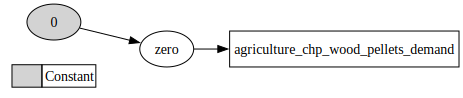

In [59]:
# Define ETLocal key
etlocal_key = "agriculture_chp_wood_pellets_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [60]:
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'agriculture_chp_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


## Export
Write the resulting filled template to a csv

In [61]:
# Write the filled template to a CSV file
path_output = Path("data", "processed", f"etlocal_template_agriculture_filled.csv")
df_template_local.to_csv(path_output, sep=sep)